<a href="https://colab.research.google.com/github/devans18/BP0268756-Call-Forecasting/blob/main/prophet_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Research into tweaking - [Non-Daily Data ](https://facebook.github.io/prophet/docs/non-daily_data) suggests that intraday forecasts can be made by setting the timestamp to

> YYYY-MM-DD HH:MM:SS



The changepoint_prior_scale variable relates to the fitting of the forecast, allowing for tweaking if over or underfit. It's unlikely to actually be needed - see [Adjusting trend flexibility](https://facebook.github.io/prophet/docs/trend_changepoints.html)

make_future_dataframe method has the variables periods and frequency. This stipulates how far into the future to forecast. As the input data will be in 15 minute intervals, we can ask prophet to forecast out in 15 minute intervals, in the following example, 14 days

`future = m.make_future_dataframe(periods=14*24*4, freq='15T')  # 14 days * 24 hours/day * 4 intervals/hour`

Also the requirement to restrict the forecasts out of hours which can be done by tweaking the forecasting code to the snapshop below.

```
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6] ## This removes any "future" data hours over 6
fcst = m.predict(future2)
fig = m.plot(fcst)
```

Further allowance can be taken for data which should be cleansed from the original dataset. Prophet can handle intervals that are blank and not inclde them in the forecast. Creation of a dataset including any 15 minute intervals should then be used to manipulate the original dataset. Something along the lines of the below code.



```
import pandas as pd

dates = pd.DataFrame({"time": ["2024-01-01 00:00:00", "2024-01-01 00:15:00", "2024-01-01 00:30:00", "2024-01-01 00:45:00", "2024-01-01 01:00:00"], "vol": [7, 14, 21, 28, 35]})

remove = pd.DataFrame({"time": ["2024-01-01 00:15:00", "2024-01-01 01:00:00"]})

print(dates)
print(remove)

dates.loc[dates['time'].isin(remove['time']), 'vol'] = None
print(dates)
```

Prophet can also handle [holidays](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special) and other events that may skew the data, which are then likely to occur again. There are two aspects - "holidays" or events that are known to skew things like black friday etc, as well as bank holidays. Known holidays can be factored using dataframes and then inserted into the model



```
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)
```





Bank holidays can be handled by the following


```
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name="GB")
m.fit(df)
```





In [ ]:
!pip install prophet --quiet


In [2]:
## Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
from prophet import Prophet

In [3]:
## Injest data

df = pd.read_csv("input.csv")
print(df.head())
print(df.tail())

                 ds   y
0  2023-01-01 08:00  15
1  2023-01-01 08:15  20
2  2023-01-01 08:30  18
3  2023-01-01 08:45  16
4  2023-01-01 09:00  16
                     ds    y
32072  2024-10-25 13:15  379
32073  2024-10-25 13:30  342
32074  2024-10-25 13:45  428
32075  2024-10-25 14:00  388
32076  2024-10-25 14:15  414


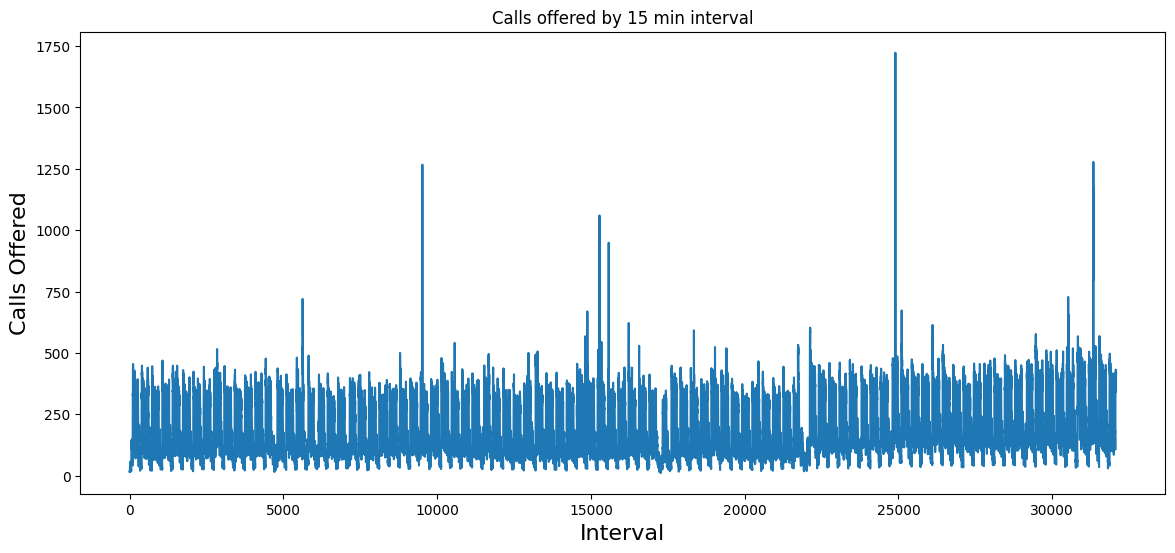

In [ ]:
## Analyse code

#plot the chart
plt.figure(figsize=(14,6))
plt.title('Calls offered by 15 min interval')
plt.plot(df["y"])
plt.xlabel('Interval', fontsize=16)
plt.ylabel('Calls Offered' , fontsize=16)
plt.show()

In [4]:
## Holidays

holidays = pd.DataFrame({
    'ds': ['2023-12-25'],
    'holiday': ['Christmas']
})

In [21]:
## Model

m = Prophet(changepoint_prior_scale=0.04).fit(df) # 0.05 is the default value and controls how much "flexibility" the model has. the higher the value, the better the seasonality detection, however it is then subject to noise.
# m = Prophet(n_changepoints=25) # 25 is the default value and this controls the number of identified Changepoints which are points in time where the trend of the time series changes significantly.
m = Prophet(holidays=holidays) # Add holidays to prophet
m.add_country_holidays(country_name="GB")
m = Prophet(daily_seasonality=True, weekly_seasonality=20)
m.add_seasonality(name="intraday", period=1, fourier_order=30)
# m = Prophet(yearly_seasonality=True) # Create a Prophet model with yearly seasonality
m.fit(df)

future = m.make_future_dataframe(periods=14*24*4, freq='15min') # 14 days * 24 hours/day * 4 intervals/hour
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour >= 8] ## This removes any "future" data hours before 8am
future2 = future2[future2['ds'].dt.hour < 20] ## This removes any "future" data hours after 8pm
future2 = future2[future2['ds'] > max(df["ds"])]
# print(future2.head())
# print(future2.tail())

fcst = m.predict(future2)
# fig = m.plot(fcst)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8kt3p4y8/l4292w4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8kt3p4y8/xozf4k3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81379', 'data', 'file=/tmp/tmp8kt3p4y8/l4292w4q.json', 'init=/tmp/tmp8kt3p4y8/xozf4k3a.json', 'output', 'file=/tmp/tmp8kt3p4y8/prophet_modeljlscmr1f/prophet_model-20241108182156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

In [ ]:
print(fcst.head())
print(fcst.tail())

                   ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2024-10-25 14:30:00  676.412834  295.437784  443.533076   676.412834   
1 2024-10-25 14:45:00  676.407437  295.875705  440.104638   676.407437   
2 2024-10-25 15:00:00  676.402040  287.287282  434.796835   676.402040   
3 2024-10-25 15:15:00  676.396643  282.948344  437.490816   676.396643   
4 2024-10-25 15:30:00  676.391245  280.839015  428.926124   676.391245   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   676.412834     -308.454758           -308.454758           -308.454758   
1   676.407437     -310.024228           -310.024228           -310.024228   
2   676.402040     -312.949304           -312.949304           -312.949304   
3   676.396643     -317.464447           -317.464447           -317.464447   
4   676.391245     -323.704334           -323.704334           -323.704334   

        daily  ...     weekly  weekly_lower  weekly_upper     yearly  \
0 -420.898118 

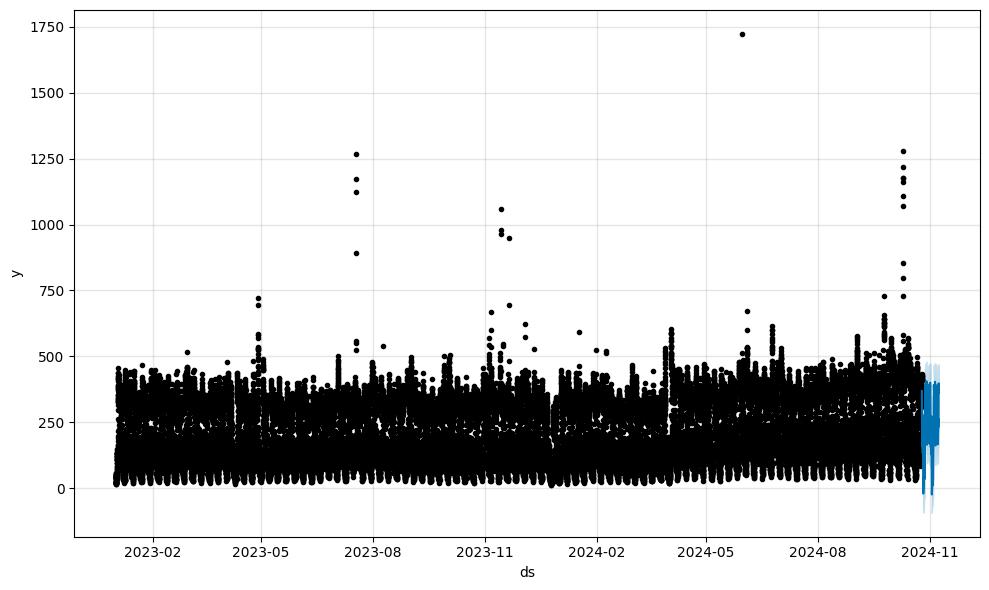

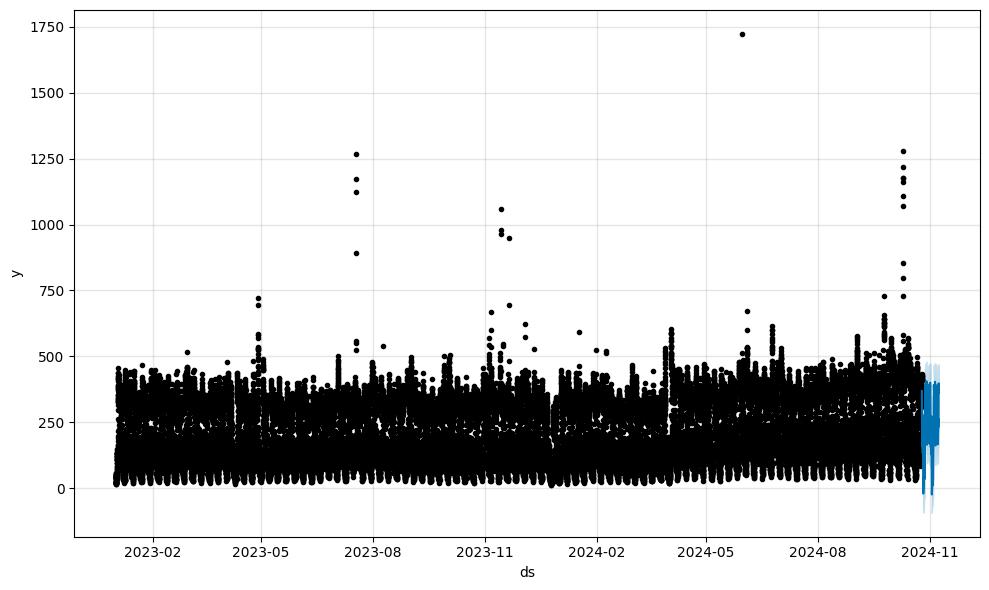

In [7]:
m.plot(fcst)

In [22]:
## export forecast to csv

fcst.to_csv("output.csv", index=False)


BELOW IS CODE FOR FORECASTING ETH VALUES - IGNORE

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

In [ ]:
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2016-01-01'

eth_df = yf.download('ETH-USD',start_date, today)

eth_df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-20,"$2,439.64","$2,993.15","$2,170.23","$2,784.29","$2,784.29",67610826680
2021-05-21,"$2,772.34","$2,938.21","$2,113.35","$2,430.62","$2,430.62",53774070802
2021-05-22,"$2,436.01","$2,483.98","$2,168.12","$2,295.71","$2,295.71",42089937660
2021-05-23,"$2,298.37","$2,384.41","$1,737.47","$2,109.58","$2,109.58",56005721977
2021-05-24,"$2,145.73","$2,544.05","$2,091.07","$2,532.89","$2,532.89",53217079296


In [ ]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2016-01-01 to 2021-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1967 non-null   float64
 1   High       1967 non-null   float64
 2   Low        1967 non-null   float64
 3   Close      1967 non-null   float64
 4   Adj Close  1967 non-null   float64
 5   Volume     1967 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 107.6 KB


In [ ]:
eth_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
eth_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
eth_df.reset_index(inplace=True)
eth_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df = eth_df[["Date", "Open"]]

new_names = {
    "Date": "ds",
    "Open": "y",
}

df.rename(columns=new_names, inplace=True)

In [ ]:
df.tail()

,ds,y
1962,2021-05-20,"$2,439.64"
1963,2021-05-21,"$2,772.34"
1964,2021-05-22,"$2,436.01"
1965,2021-05-23,"$2,298.37"
1966,2021-05-24,"$2,145.73"


In [ ]:
# plot the open price

x = df["ds"]
y = df["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot of Ethereum Open Price",
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)

In [ ]:
m = Prophet(
    seasonality_mode="multiplicative"
)

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods = 365)
future.tail()

,ds
2327,2022-05-20
2328,2022-05-21
2329,2022-05-22
2330,2022-05-23
2331,2022-05-24


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2327,2022-05-20,"$5,852.34","$3,563.80","$7,976.08"
2328,2022-05-21,"$5,660.44","$3,394.47","$7,724.64"
2329,2022-05-22,"$5,457.99","$3,287.26","$7,428.27"
2330,2022-05-23,"$5,231.01","$3,158.21","$7,164.88"
2331,2022-05-24,"$5,054.01","$3,019.28","$6,942.42"


In [ ]:
next_day = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

forecast[forecast['ds'] == next_day]['yhat'].item()

2525.5788173913843

In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)